# **Stage 2 - Deep Reinforcement Learning for Infinite Impulse Response (IIR) Filter Implementation - part 2** 

## Scope - *analyzing reasons for the random behavior in learning performance of curret model for IIR filters*
References:- Chapter 11 of *Digital Signal Processing: signals, systems, and filters* by *Andreas Antoniou* 

In [7]:
import os, sys, json
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import lfilter, zpk2tf

import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform

import gymnasium as gym 
from gymnasium import spaces

sys.path.append('../')
from stage1_helper import create_target_and_jammed_signals, SNR
from stage2_helper import polar2cmplx

In [2]:
# DEFINE CONSTANTS
S = 100 # state size (length of the state audio sample sequence)
SAMPLING_FREQ = 44_100 # Hz
TRUNCATION_FREQ = 5_000 # Hz
INTERFERENCE_CENTER_FREQ = 15_000 # Hz

In [5]:
# redefine the environment locally...
class ReceiverEnvWithSecondOrderIIR(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver of jammed audio with IIR filtering. 
    :param S: signal partition size which represents a state 
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf

    def __init__(self, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = '/home/akila/FYP/coding/stage_1/audio_files/audio_files.json'):

        super(ReceiverEnvWithSecondOrderIIR, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing fixed gain k, zeros, and poles of an N-th order IIR filter
        # note that the action is NOT TUNING/,ADJUSTING, or CHANGING the coefficeints of an existing filter. 
        action_shape = (5, )
        self.action_space = spaces.Box(low=0, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32, lower limit must be 0. 

        # ----------------------------- State Space ------------------------------
        state_shape = (self.S, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class attributes ------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None

        # set show_effect option
        self.show_effect = True
        if isinstance(options, dict) and 'show_effect' in options:
            self.show_effect = options['show_effect']
        
        # reset the counters
        if isinstance(options, dict) and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 0 # default audio track - 'vignesh.wav'
        if isinstance(options, dict) and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(train_audio_names[audio_num], self.cut_off_freq, self.interference_center_freq, self.S)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal
        print()

        # return the initial state 
        self.state = jammed_signal[:self.S]

        # declare the initial conditions in the start of the audio
        self.initial_conds = np.zeros(2)

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # ----- create the filter -----
        # extract the zero, pole, and gain, and find the transfer function of the filter
        z = polar2cmplx(action[0], np.pi * action[1])
        p = polar2cmplx(action[2], np.pi * action[3])
        k = action[4]

        zs = (z, np.conjugate(z)) # array of zeros of TF
        ps = (p, np.conjugate(p)) # array of poles of TF

        b, a = zpk2tf(zs, ps, k)

        # get signal partition from the buffer
        partition = self.state

        # generating the next state
        terminated = False
        if self.S * (self.counter + 1) >= len(self.jammed_signal):
            terminated = True
        else:
            self.state = self.jammed_signal[self.S * self.counter : self.S * (self.counter + 1)]
        
        # apply the IIR filter to the current state and set the initial conditions for the next state
        filtered, self.initial_conds = lfilter(b, a, partition, zi=self.initial_conds)
        target = self.target_signal[self.S * (self.counter - 1) : self.S * self.counter]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            print(f"reward value is not a number... \nfilter: {filter}; assigning -20dB as the reward...")
            reward = -20 # assign a very large negative reward
            # raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        if self.show_effect: print(f"step: {self.counter}, SNR: {reward}, filter: {b}, {a}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {} 

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

In [8]:
# redefine the DDPG Agent
# =============================== REPLAY BUFFER ===============================
class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory     = np.zeros((self.mem_size, *state_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape))
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool_) # using np.bool is really useful when pytorch is used.

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size # implement a queue

        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index]  = done # problematic !!!

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False) # replace = False -> in a single batch, no element gets sampled more than once. 

        states     = self.state_memory[batch]
        actions    = self.action_memory[batch]
        rewards    = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones      = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones



# =============================== CRITIC NETWORK ===============================
class CriticNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(CriticNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 
        # extensions for saving keras models: legacy '.h5' -> TF 1.X, '.tf' -> TF 2.X

        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # # define network layers 
        # self.fc1 = Dense(self.fc1_dims, activation='relu')
        # self.fc2 = Dense(self.fc2_dims, activation='relu')
        # self.q   = Dense(1, activation=None)

        # # define network layers 
        # self.hidden1  = Dense(self.fc1_dims, activation='relu', name="critic_hidden1")
        # self.hidden2  = Dense(self.fc2_dims, activation='relu', name="critic_hidden2")
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # self.hidden2_ = Dense(self.fc2_dims, activation='relu', name="critic_hidden2_")
        # self.q        = Dense(1, activation=None, name="q_value") # change the activation appropriately

        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)

        # define network layers
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims,
            activation='relu',
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name="critic_hidden1"
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2"
        )
        self.action_normalizer  = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2_ = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2_"
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.q = Dense(
            units=1,
            activation=None, # None
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name="q_value"
        )

    def call(self, state, action):
        # # temp1 = self.fc1(tf.concat([state, action], axis=1)) # axis 0 -> batch dimension
        # temp1 = self.fc1(action)
        # # ######################## PROBLEM ########################
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # temp2 = self.fc2(temp1)
        # q_value = self.q(temp2)

        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_action  = self.action_normalizer(action) # may not be required since action is already bounded between [-1, +1], but they may be too small compared to normalized_hidden1 activations
        # hidden2_           = self.hidden2_(normalized_action)
        hidden2_           = self.hidden2_(action)
        normalized_hidden2 = self.hidden2_normalizer(tf.concat([hidden2, hidden2_], axis=1)) ######
        q_value            = self.q(normalized_hidden2)
        # q_value = self.q(tf.concat([hidden2, hidden2_], axis=1))

        return q_value

# ================================ ACTOR NETWORK ===============================
class ActorNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            n_actions, # action shape (dimenisonality of action space)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 

        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # weight and bias initialziers
        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)
        
        # define network layers including layer noramlizations
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name='actor_hidden1'
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name='actor_hidden2'
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.mu = Dense(
            units=n_actions,
            activation='sigmoid', # limit the action in the range [0, 1] -> 'sigmoid'
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name='action'
        )

    def call(self, state):
        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_hidden2 = self.hidden2_normalizer(hidden2)
        # action             = self.mu(normalized_hidden2)
        action             = self.mu(hidden2)

        return action



# ================================== DDPG AGENT =================================
class DDPGAgent:
    def __init__(
            self,
            input_dims, # state shape
            n_actions,  # dimensionality of actions
            # env,        # gymnasium env
            alpha,      # learning rate of actor
            beta,       # learning rate of critic
            gamma,      # discounting factor
            tau,        # soft target update factor
            critic_fc1,
            critic_fc2,
            actor_fc1,
            actor_fc2,
            batch_size,
            buffer_size,
            noise
    ):
        # set the class attributes
        self.tau = tau
        self.n_actions = n_actions
        self.noise = noise
        self.batch_size = batch_size
        self.gamma = gamma

        # instantiate replay buffer
        self.memory = ReplayBuffer(buffer_size, state_shape=input_dims, n_actions=n_actions)

        # instantiate the networks
        self.actor  = ActorNetwork(name="actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.critic = CriticNetwork(name="critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)
        self.target_actor  = ActorNetwork(name="target_actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.target_critic = CriticNetwork(name="target_critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)

        # compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # target networks do not require an optimizer or a learning rate since they are learned through soft updates.
        # but, to use the networks in TF2, we have to compile them with an optimizer and a learning rate. 
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # load identical weights to target networks
        self.update_target_network_parameters(tau=1)

    def update_target_network_parameters(self, tau=None):
        if tau == None:
            tau = self.tau

        target_actor_weights = self.target_actor.weights
        for i, actor_weights in enumerate(self.actor.weights):
            target_actor_weights[i] = tau * actor_weights + (1-tau) * target_actor_weights[i]
        self.target_actor.set_weights(target_actor_weights)

        target_critic_weights = self.target_critic.weights
        for i, critic_weights in enumerate(self.critic.weights):
            target_critic_weights[i] = tau * critic_weights + (1-tau) * target_critic_weights[i]
        self.target_critic.set_weights(target_critic_weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... saving models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.save_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.save_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.save_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.save_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def load_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... loading models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.load_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.load_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.load_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.load_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32) # introducing the batch dimension
        action = self.actor(state) # 'action' would also have a batch dimension 

        if not evaluate:
            # while training the agent, introduce an exploration noise
            # here, the exploration noise is sampled from a normal distribution with zero mean and specified std deviation. 
            action += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.noise)
            # when added the noise, the action can go beyond the action space limits; so, clip the actions.
            action = tf.clip_by_value(action, clip_value_max=1.0, clip_value_min=-1.0)

        return action[0] # get rid of the batch dimension
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states     = tf.convert_to_tensor(state, dtype=tf.float32)
        actions    = tf.convert_to_tensor(action, dtype=tf.float32)
        rewards    = tf.convert_to_tensor(reward, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_state, dtype=tf.float32)

        # update the critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            next_step_critic_values = tf.squeeze(self.target_critic(new_states, target_actions), axis=1)
            critic_values = tf.squeeze(self.critic(states, actions), axis=1)
            targets = rewards + self.gamma * next_step_critic_values * (1-done) # y_i
            critic_loss = MSE(targets, critic_values)
        
        critic_network_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradients, self.critic.trainable_variables))

        # update the actor
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            critic_values_ = -self.critic(states, new_policy_actions) # why (-) ? gradient ascent
            actor_loss = tf.math.reduce_mean(critic_values_)

        actor_network_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradients, self.actor.trainable_variables))

        # soft target updates
        self.update_target_network_parameters()

In [9]:
# redefine train and test functions
def train(model_, env_, audio_num, max_num_steps, show_effect=True, reward_history=None, action_history=None):
    """
    Trains a model in a given environment over a specified number of time steps.
    :param model_: the DRL model 
    :param env_: the environment the model is going to trained in
    :param audio_num: the number/index of the audio track to be used as the training data
    :param max_num_steps: the maximum number of time steps for training

    Returns None
    """

    if reward_history == None: reward_history = [][:]
    if action_history == None: action_history = []
    step_count = 0

    # reset the environment
    state, _ = env_.reset(options={'reset_all': True, 'audio_num':audio_num, 'show_effect': show_effect}) # FOR SINGLE EPISODE
    done = False

    while not done:
        # feed the state to the agent (model) and get an action
        action = model_.choose_action(state).numpy() # this includes the exploration noise

        # take the action in the environment
        next_state, reward, terminated, truncated, _ = env_.step(action)
        done = terminated | truncated
        step_count += 1

        # store the transition in the replay buffer of the DDPG agent
        model_.remember(state, action, reward, next_state, done)

        # train the model
        model_.learn()

        # set the `next_state` as `state`
        state = next_state

        # keep track of `reward` and `action`
        reward_history.append(reward)
        action_history.append(action)
        
        if step_count >= max_num_steps:
            done = True

    return reward_history, action_history


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'rain_on_me-MONO'
sampling rate: 44100 Hz
audio shape: (8305664,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -18879.494656565814 (>=-32768) to max: 17182.003427808108 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 23603 and upper -250474 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49095.53950461225 (>=-2147483648) to max: 49100.5372207998 (<=2147483647)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296

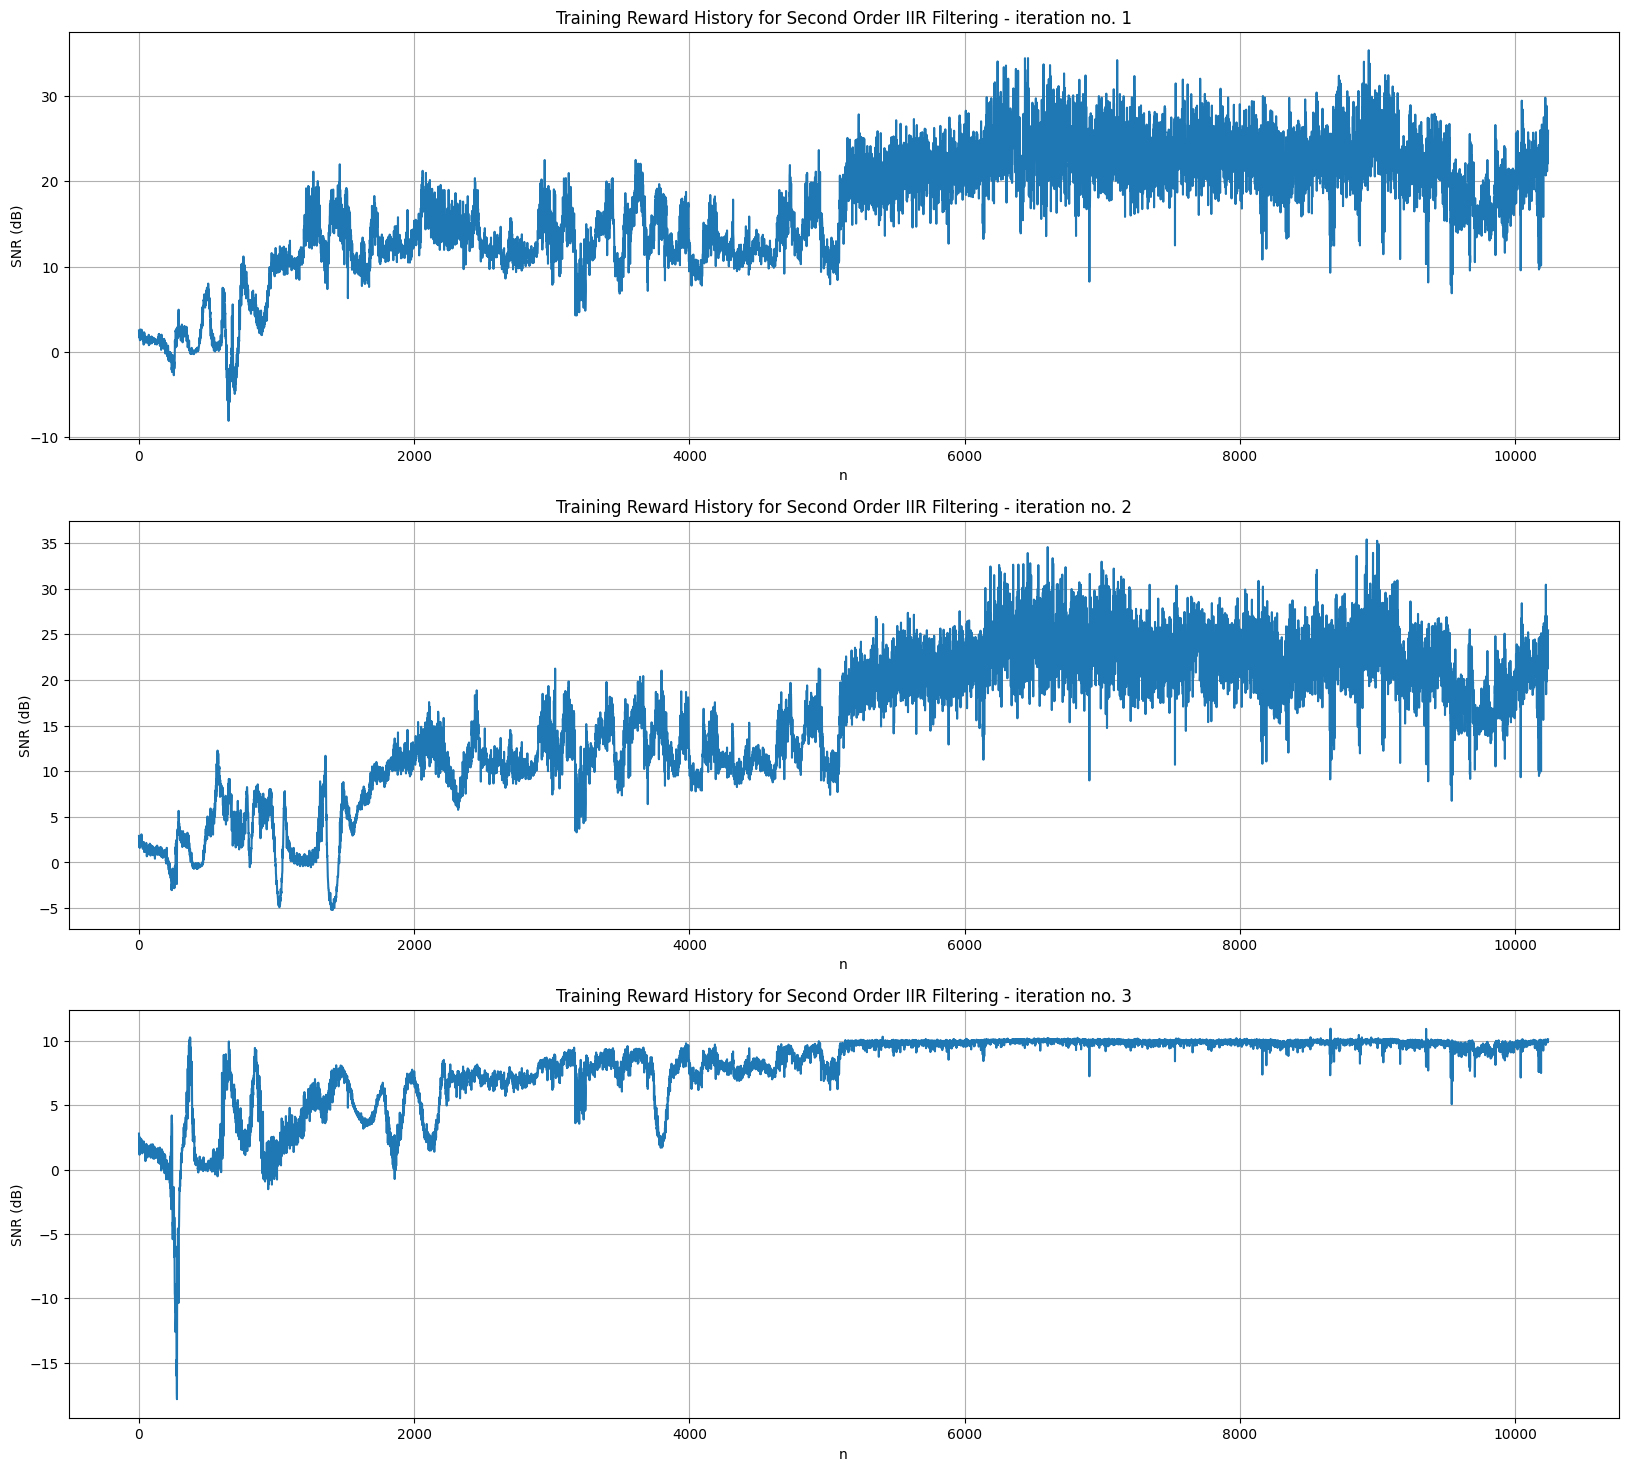

In [11]:
# declare a new environment instance
env_ = ReceiverEnvWithSecondOrderIIR(S, cut_off_freq=TRUNCATION_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ)

# run the training for few iterations
step_num = 3
fig, ax = plt.subplots(nrows=step_num, ncols=1, figsize=(20, 6*step_num))

for i in range(step_num):

    # launch a new DDPG agent
    keras.backend.clear_session()
    model_2 = DDPGAgent(
        input_dims  = env_.observation_space.shape,
        n_actions   = env_.action_space.shape[0],
        alpha       = 0.0001, # learning rate of actor
        beta        = 0.001,  # learning rate of critic
        gamma       = 0.1,
        tau         = 0.001,
        critic_fc1  = 512,
        critic_fc2  = 256, #...
        actor_fc1   = 256,
        actor_fc2   = 128,
        batch_size  = 128,
        buffer_size = 2000,
        noise       = 0.01
    )

    # train the model
    train_time_steps = 128*40
    reward_history_2, action_history_2 = train(model_2, env_, audio_num=4, max_num_steps=train_time_steps, show_effect=False)
    reward_history_2, action_history_2 = train(model_2, env_, audio_num=1, max_num_steps=train_time_steps, show_effect=False, reward_history=reward_history_2, action_history=action_history_2)

    ax[i].plot(range(1, len(reward_history_2)+1), reward_history_2)
    ax[i].set_title(f"Training Reward History for Second Order IIR Filtering - iteration no. {i+1}")
    ax[i].set_xlabel("n")
    ax[i].set_ylabel("SNR (dB)")
    ax[i].grid(True)

In [37]:
weight_initializer = RandomUniform(minval=-1, maxval=1, seed=0)
input = keras.layers.Input(
    shape = (5, )
)
layer = Dense(
    units=5,
    kernel_initializer = weight_initializer,
    bias_initializer = weight_initializer
)
model__ = keras.Sequential()
model__.add(input)
model__.add(layer)

model__.compile(
    optimizer = Adam(learning_rate=0.001)
)
print(model__.summary())
print('\n', model__.weights)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 5)                 30        
                                                                 
Total params: 30 (120.00 Byte)
Trainable params: 30 (120.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

 [<tf.Variable 'dense_24/kernel:0' shape=(5, 5) dtype=float32, numpy=
array([[-0.5779691 ,  0.41201997,  0.60012674,  0.5415845 , -0.22282267],
       [ 0.74071884,  0.61637497, -0.6061182 ,  0.6985414 ,  0.08035207],
       [-0.72782993, -0.77760625,  0.49419427, -0.6052685 , -0.28451157],
       [ 0.04059649, -0.1477232 , -0.57748985, -0.5648031 , -0.6823611 ],
       [-0.6720817 ,  0.9947593 , -0.17382574, -0.59943295,  0.4406891 ]],
      dtype=float32)>, <tf.Variable 'dense_24/bias:0' shape=(5,) dtype=float32, numpy=
array([-0.5

In [39]:
# redefine the DDPG Agent
# =============================== REPLAY BUFFER ===============================
class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        # np.random.seed(0)

        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory     = np.zeros((self.mem_size, *state_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape))
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool_) # using np.bool is really useful when pytorch is used.

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size # implement a queue

        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index]  = done # problematic !!!

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size) # here, mem_size is same as batch_size, and initially, mem_cntr is same as batch_size, so max_mem would always be batch_size. 

        batch = np.random.choice(max_mem, batch_size, replace=False) # replace = False -> in a single batch, no element gets sampled more than once. 
        if not np.array_equal(np.sort(batch), np.arange(batch_size)):
            raise Exception(f"batch selection is not deterministic; batch indices - {np.sort(batch)}")

        states     = self.state_memory[batch]
        actions    = self.action_memory[batch]
        rewards    = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones      = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones



# =============================== CRITIC NETWORK ===============================
class RamdomlessCriticNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(RamdomlessCriticNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 
        # extensions for saving keras models: legacy '.h5' -> TF 1.X, '.tf' -> TF 2.X

        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # # define network layers 
        # self.fc1 = Dense(self.fc1_dims, activation='relu')
        # self.fc2 = Dense(self.fc2_dims, activation='relu')
        # self.q   = Dense(1, activation=None)

        # # define network layers 
        # self.hidden1  = Dense(self.fc1_dims, activation='relu', name="critic_hidden1")
        # self.hidden2  = Dense(self.fc2_dims, activation='relu', name="critic_hidden2")
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # self.hidden2_ = Dense(self.fc2_dims, activation='relu', name="critic_hidden2_")
        # self.q        = Dense(1, activation=None, name="q_value") # change the activation appropriately

        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims), seed=0)
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims), seed=0)
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4, seed=0)

        # define network layers
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims,
            activation='relu',
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name="critic_hidden1"
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2"
        )
        self.action_normalizer  = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2_ = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2_"
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.q = Dense(
            units=1,
            activation=None, # None
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name="q_value"
        )

    def call(self, state, action):
        # # temp1 = self.fc1(tf.concat([state, action], axis=1)) # axis 0 -> batch dimension
        # temp1 = self.fc1(action)
        # # ######################## PROBLEM ########################
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # temp2 = self.fc2(temp1)
        # q_value = self.q(temp2)

        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_action  = self.action_normalizer(action) # may not be required since action is already bounded between [-1, +1], but they may be too small compared to normalized_hidden1 activations
        # hidden2_           = self.hidden2_(normalized_action)
        hidden2_           = self.hidden2_(action)
        normalized_hidden2 = self.hidden2_normalizer(tf.concat([hidden2, hidden2_], axis=1)) ######
        q_value            = self.q(normalized_hidden2)
        # q_value = self.q(tf.concat([hidden2, hidden2_], axis=1))

        return q_value

# ================================ ACTOR NETWORK ===============================
class RandomlessActorNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            n_actions, # action shape (dimenisonality of action space)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(RandomlessActorNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 

        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # weight and bias initialziers
        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims), seed=0)
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims), seed=0)
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4, seed=0)
        
        # define network layers including layer noramlizations
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name='actor_hidden1'
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name='actor_hidden2'
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.mu = Dense(
            units=n_actions,
            activation='sigmoid', # limit the action in the range [0, 1] -> 'sigmoid'
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name='action'
        )

    def call(self, state):
        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_hidden2 = self.hidden2_normalizer(hidden2)
        # action             = self.mu(normalized_hidden2)
        action             = self.mu(hidden2)

        return action



# ================================== DDPG AGENT =================================
class RandomlessDDPGAgent:
    def __init__(
            self,
            input_dims, # state shape
            n_actions,  # dimensionality of actions
            # env,        # gymnasium env
            alpha,      # learning rate of actor
            beta,       # learning rate of critic
            gamma,      # discounting factor
            tau,        # soft target update factor
            critic_fc1,
            critic_fc2,
            actor_fc1,
            actor_fc2,
            batch_size,
            buffer_size,
            noise
    ):
        # set the class attributes
        self.tau = tau
        self.n_actions = n_actions
        self.noise = noise
        self.batch_size = batch_size
        self.gamma = gamma

        # instantiate replay buffer
        self.memory = ReplayBuffer(buffer_size, state_shape=input_dims, n_actions=n_actions)

        # instantiate the networks
        self.actor  = RandomlessActorNetwork(name="actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.critic = RamdomlessCriticNetwork(name="critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)
        self.target_actor  = RandomlessActorNetwork(name="target_actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.target_critic = RamdomlessCriticNetwork(name="target_critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)

        # compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # target networks do not require an optimizer or a learning rate since they are learned through soft updates.
        # but, to use the networks in TF2, we have to compile them with an optimizer and a learning rate. 
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # load identical weights to target networks
        self.update_target_network_parameters(tau=1)

    def update_target_network_parameters(self, tau=None):
        if tau == None:
            tau = self.tau

        target_actor_weights = self.target_actor.weights
        for i, actor_weights in enumerate(self.actor.weights):
            target_actor_weights[i] = tau * actor_weights + (1-tau) * target_actor_weights[i]
        self.target_actor.set_weights(target_actor_weights)

        target_critic_weights = self.target_critic.weights
        for i, critic_weights in enumerate(self.critic.weights):
            target_critic_weights[i] = tau * critic_weights + (1-tau) * target_critic_weights[i]
        self.target_critic.set_weights(target_critic_weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... saving models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.save_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.save_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.save_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.save_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def load_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... loading models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.load_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.load_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.load_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.load_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32) # introducing the batch dimension
        action = self.actor(state) # 'action' would also have a batch dimension 

        if not evaluate:
            # while training the agent, introduce an exploration noise
            # here, the exploration noise is sampled from a normal distribution with zero mean and specified std deviation. 
            action += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.noise)
            # when added the noise, the action can go beyond the action space limits; so, clip the actions.
            action = tf.clip_by_value(action, clip_value_max=1.0, clip_value_min=-1.0)

        return action[0] # get rid of the batch dimension
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states     = tf.convert_to_tensor(state, dtype=tf.float32)
        actions    = tf.convert_to_tensor(action, dtype=tf.float32)
        rewards    = tf.convert_to_tensor(reward, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_state, dtype=tf.float32)

        # update the critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            next_step_critic_values = tf.squeeze(self.target_critic(new_states, target_actions), axis=1)
            critic_values = tf.squeeze(self.critic(states, actions), axis=1)
            targets = rewards + self.gamma * next_step_critic_values * (1-done) # y_i
            critic_loss = MSE(targets, critic_values)
        
        critic_network_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradients, self.critic.trainable_variables))

        # update the actor
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            critic_values_ = -self.critic(states, new_policy_actions) # why (-) ? gradient ascent
            actor_loss = tf.math.reduce_mean(critic_values_)

        actor_network_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradients, self.actor.trainable_variables))

        # soft target updates
        self.update_target_network_parameters()

- The weight initializers used in both actor and critic networks are seeded with 0; therefore, there is no randomness in initial weights of the network.
- To make the choice of a batch out of the samples in the Replay Buffer, make the buffer size and the batch size equal. 
- To avoid the randomness induced by the exploration noise, set `noise` input argument of `RandomlessDDPGAgent` to 0. 
- If our assumption of the randomness of the model training is completely caused by the above 3 sources, then the following runs must result in identical learning curves... 

In [40]:
# launch a deterministic (randomless) DDPG agent
randomless_model = RandomlessDDPGAgent(
    input_dims  = env_.observation_space.shape,
    n_actions   = env_.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 512,
    critic_fc2  = 256, #...
    actor_fc1   = 256,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 128, # buffer_size == batch_size
    noise       = 0
)
# train the model
train_time_steps = 128*40
rl_reward_history, rl_action_history = train(randomless_model, env_, audio_num=4, max_num_steps=train_time_steps, show_effect=False)
rl_reward_history, rl_action_history = train(randomless_model, env_, audio_num=1, max_num_steps=train_time_steps, show_effect=False, reward_history=rl_reward_history, action_history=rl_action_history)
